In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [29]:
BATCH_SIZE = 32
IMAGE_SIZE=300
CHANNELS=3
EPOCHS=20

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2626 files belonging to 5 classes.


In [13]:
class_names = dataset.class_names
class_names

['APPLES', 'BANANA', 'ORANGE', 'PINEAPPLE', 'WATERMELON']

In [14]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[2 2 2 0 1 0 3 2 0 1 4 0 3 3 1 1 0 3 0 0 0 3 3 0 2 3 0 3 0 1 2 4]


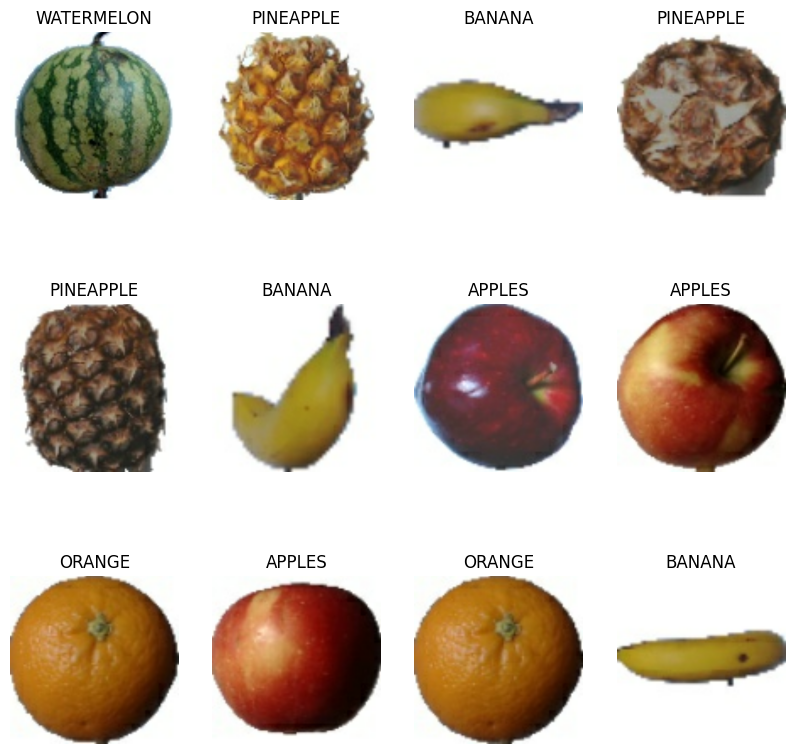

In [15]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

66

In [19]:
len(val_ds)

8

In [20]:
len(test_ds)

9

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 149, 149, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 73, 73, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 71, 71, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
66/66 [==============================] - 132s 2s/step - loss: 0.7154 - accuracy: 0.7051 - val_loss: 0.3122 - val_accuracy: 0.8789
Epoch 2/20
66/66 [==============================] - 111s 2s/step - loss: 0.0403 - accuracy: 0.9894 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 3/20
66/66 [==============================] - 115s 2s/step - loss: 0.0180 - accuracy: 0.9933 - val_loss: 0.0113 - val_accuracy: 0.9961
Epoch 4/20
66/66 [==============================] - 120s 2s/step - loss: 0.0533 - accuracy: 0.9851 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/20
66/66 [==============================] - 115s 2s/step - loss: 9.0093e-04 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/20
66/66 [==============================] - 115s 2s/step - loss: 9.0444e-05 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 7/20
66/66 [==============================] - 116s 2s/step - loss: 5.3588e-05 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
E

In [31]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 12s 363ms/step - loss: 0.0016 - accuracy: 1.0000


In [32]:
scores

[0.0015714461915194988, 1.0]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 66}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

20

In [38]:
history.history['loss'][:5]

[0.7153558135032654,
 0.04027513414621353,
 0.018003839999437332,
 0.05330031365156174,
 0.0009009321802295744]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

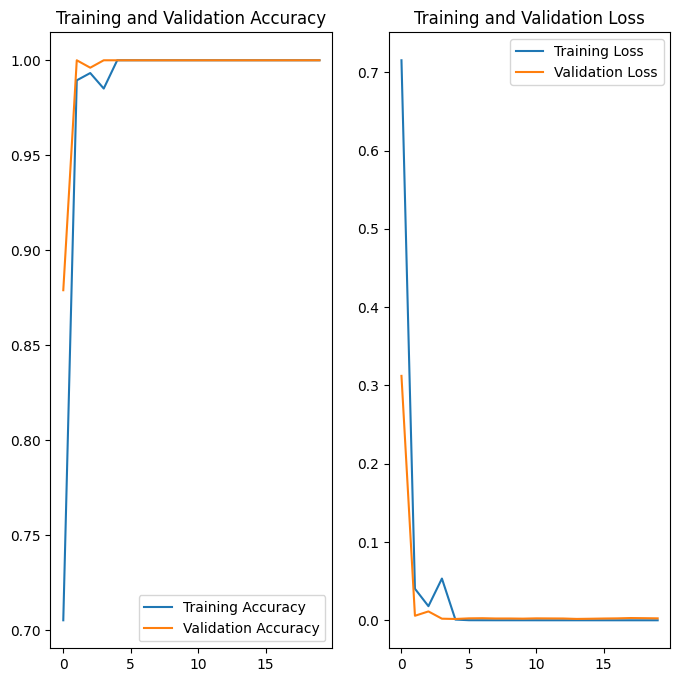

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: APPLES
1/1 [==============================] - 1s 729ms/step
predicted label: APPLES


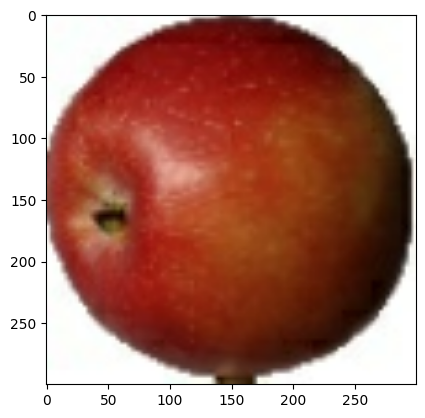

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


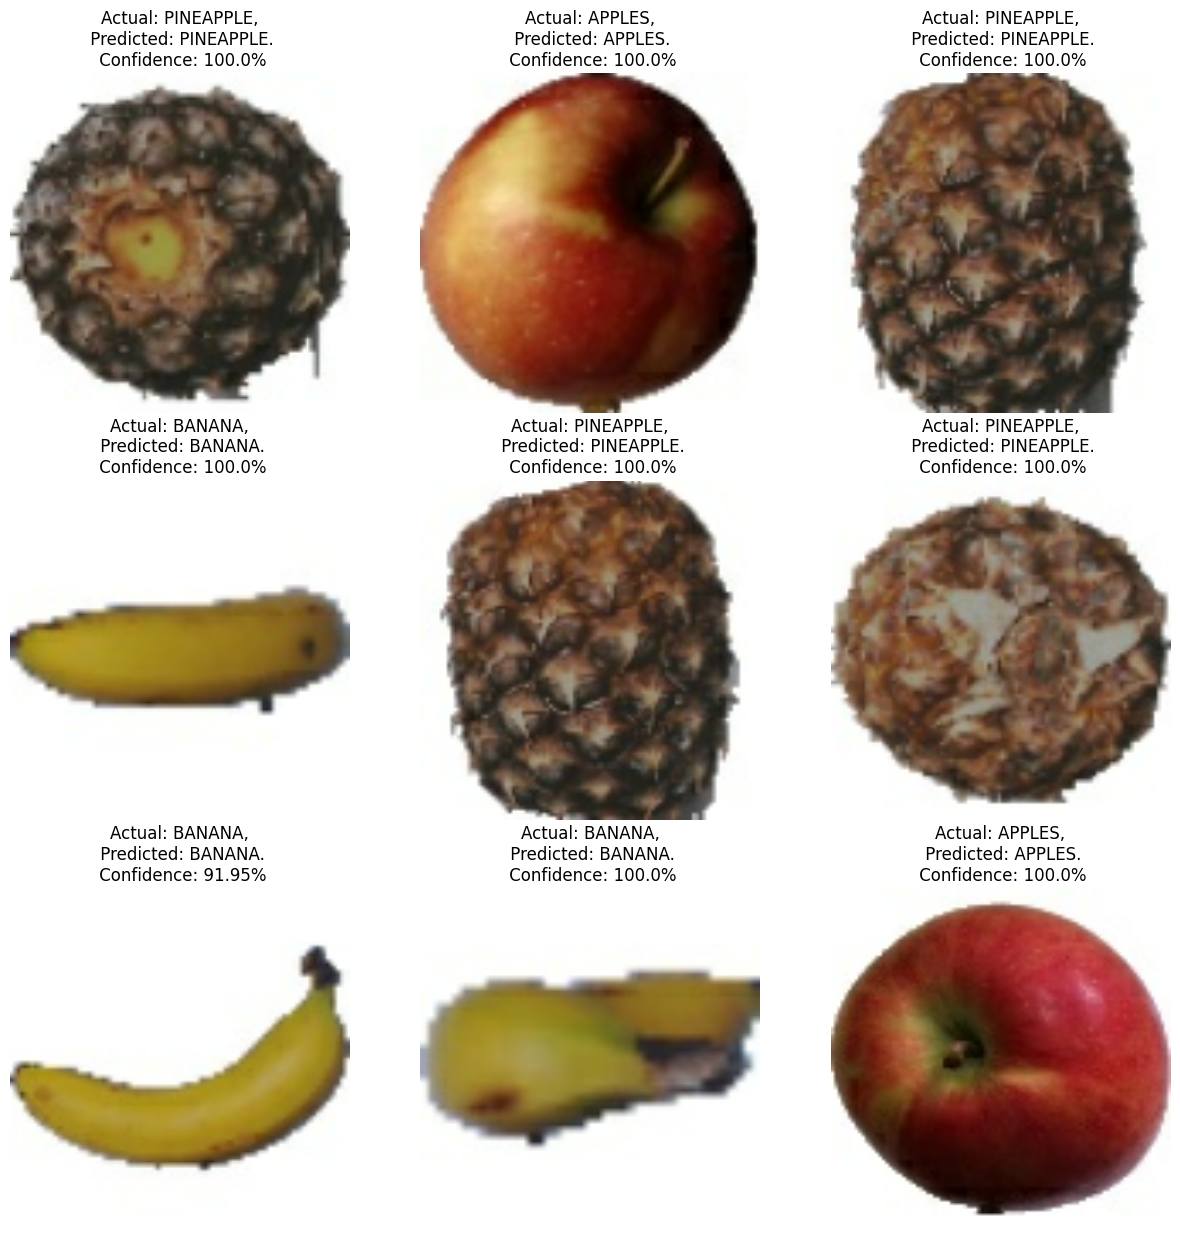

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [46]:
model.save("models/fruits.h5")